### Library Imports

This code cell imports essential libraries used throughout the notebook:

- **Standard libraries**: `os`, `glob`, `random` for file and system operations.
- **Image processing**: `cv2` (OpenCV) and `matplotlib` for image I/O and visualization.
- **Numerical operations**: `numpy`, `pandas` for data handling.
- **Progress tracking**: `tqdm` for visual progress bars.
- **Machine learning**: 
  - `sklearn` for data splitting, label encoding, and metrics.
  - `torch`, `torchvision`, and `timm` for deep learning models and utilities.
- **AMP (Automatic Mixed Precision)**: `autocast`, `GradScaler` for optimizing training performance and memory usage.

In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from tqdm import tqdm

import torch
import pandas as pd
import random
from sklearn.model_selection import StratifiedGroupKFold, train_test_split
from sklearn.preprocessing import LabelEncoder
import sklearn.metrics as skm
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T
import timm
import torch.nn as nn
import torch.nn.functional as F
from torch.amp import autocast, GradScaler

### Configuration

Defines a centralized `CFG` class that holds all parameters used throughout the training pipeline. Keeping settings in one place makes the code easier to manage and reproduce.

---

**1. Model and Training Parameters**  
- `model_name`: Chooses the image backbone from the `timm` library, here using EfficientNet B4 pretrained on JFT.  
- `img_size`: Target input size for all images, resized before feeding into the model.  
- `batch_size`, `learning_rate`, `epochs`: Standard training hyperparameters.

---

**2. Cross-Validation Setup**  
- `folds`: Number of K-Folds used for cross-validation.  
- `selected_folds`: List of folds to train on, allowing flexible fold selection.  
- `seed`: Fixed random seed for reproducibility across data splits and model initialization.

---

**3. Loss Function**  
- `loss`: Option to use Focal Loss, which helps handle class imbalance by focusing more on harder-to-classify examples.

---

**4. Data Augmentation Settings**  
- `augment`: Enables or disables augmentation.  
- Geometric augmentations: horizontal flip (`hflip`), vertical flip (`vflip`), and slight rotation (`rot`).  
- Pixel-level augmentations: brightness (`bri`), contrast (`cont`), saturation (`sat`), and hue (`hue`) applied with a probability of `pixel_aug`.

These augmentations increase the diversity of training samples, helping the model generalize better to unseen cases.

In [1]:
# --- Configuration ---
class CFG:
    model_name = 'tf_efficientnet_b4.ns_jft_in1k'
    img_size = (512, 512)
    batch_size = 16
    epochs = 8
    folds = 4
    seed = 42
    selected_folds = [0, 1, 2, 3]
    learning_rate = 1e-4
    loss = 'focal'
    augment = True
    hflip = True
    vflip = True
    rot = 2.0
    cont = [0.8, 1.2]
    bri = 0.15
    sat = [0.7, 1.3]
    hue = 0.05
    pixel_aug = 0.90


### Random Seed for Reproducibility

Defines and calls a `set_seed` function to ensure reproducibility across runs by fixing random states:

- Seeds the `random`, `numpy`, and `torch` libraries.
- Ensures deterministic behavior in cuDNN (used by PyTorch on GPUs).
- Uses `CFG.seed` as the seed value (assumed to be defined elsewhere).

In [3]:
def set_seed(seed=42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
set_seed(CFG.seed)

### Load and Prepare Training Data with Encoded Auxiliary Targets

This step loads the dataset, constructs file paths for each image, and prepares the auxiliary targets for multi-task learning.

---

**1. Load CSV and Clean Image ID**  
- Reads the dataset from `trimmed_train.csv` into `train_df`.
- Converts `image_id` to a clean string using `.astype(str).str.strip()` to avoid path errors.

---

**2. Construct Image Paths**  
- Defines a helper function `get_image_path(...)` to build the file path to each ROI image using the `patient_id` and `image_id`.
- Adds a new column `image_path` to the dataframe using `apply(...)` so each row has a direct link to its image.

---

**3. Process Auxiliary Targets**  
- Fills missing `age` values with the column mean using `.fillna(...)`.
- Converts `age` into 10 equally sized bins using `pd.qcut(..., labels=False)`, turning it into a categorical feature with values from 0 to 9.
- Defines a list `AUX_TARGETS` containing all the auxiliary variables to be learned by the model alongside the cancer label.
- Applies label encoding to all categorical targets using `LabelEncoder().fit_transform(...)` to convert them to integer classes.
- Calculates `AUX_TARGET_NCLASSES` which stores the number of unique classes per target, needed when building classification heads for each auxiliary target.

---

**4. Print Class Summary**  
- Iterates through each auxiliary target to print its unique values and class counts for verification.

---

*While preprocessing of auxillary targets is also done in this notebook, it's not necessary as these targets will not be utilized in this model*

In [4]:
# LOAD TRAIN.CSV
train_df = pd.read_csv("input/trimmed_train.csv")

# CLEAN DATA
train_df['image_id'] = train_df['image_id'].astype(str).str.strip()

def get_image_path(patient_id, image_id):
    return f"input/roi/trimmed_train_images_roi/{patient_id}/{image_id}.png"

train_df['image_path'] = train_df.apply(lambda row: get_image_path(row['patient_id'], row['image_id']), axis=1)


# ENCODE AUX TARGETS
train_df['age'] = train_df['age'].fillna(train_df['age'].mean())
train_df['age'] = pd.qcut(train_df['age'], 10, labels=False).astype(int)
AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 
               'invasive', 'BIRADS', 'density', 'difficult_negative_case', 
               'machine_id', 'age']

CATEGORY_AUX_TARGETS = ['site_id', 'laterality', 'view', 'implant', 'biopsy', 'invasive', 'BIRADS', 'density', 'difficult_negative_case', 'machine_id']
train_df[CATEGORY_AUX_TARGETS] = train_df[CATEGORY_AUX_TARGETS].apply(LabelEncoder().fit_transform)
AUX_TARGET_NCLASSES = train_df[CATEGORY_AUX_TARGETS].max() + 1

for col in AUX_TARGETS:
    uniques = sorted(train_df[col].unique())
    n_classes = train_df[col].nunique()

    print(f"--- {col} ---")
    print(f"Unique labels in data: {uniques}")
    print(f"Number of classes expected: {n_classes}")
    print()

--- site_id ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- laterality ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- view ---
Unique labels in data: [0, 1, 2, 3]
Number of classes expected: 4

--- implant ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- biopsy ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- invasive ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- BIRADS ---
Unique labels in data: [0, 1, 2, 3]
Number of classes expected: 4

--- density ---
Unique labels in data: [0, 1, 2, 3, 4]
Number of classes expected: 5

--- difficult_negative_case ---
Unique labels in data: [0, 1]
Number of classes expected: 2

--- machine_id ---
Unique labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of classes expected: 10

--- age ---
Unique labels in data: [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
Number of classes expected: 10



### Stratified Train-Test Split and Fold Assignment

Split the dataset into train and test sets and prepares fold labels for cross-validation.

---

**1. Split Dataset**  
- Uses `train_test_split` to divide `train_df` into 80% training and 20% testing data.
- Stratifies based on the `cancer` label so that both subsets reflect the original class distribution.
- Sets a fixed random seed (`CFG.seed`) to ensure reproducibility of the split.

Using stratification keeps the cancer label balanced in both sets, and the test set is saved for final evaluation.

---

**2. Reset Indexes**  
- Resets the indices of both training and test DataFrames with `.reset_index(drop=True)`.

This ensures that the row indices are clean and consistent after the split, which avoids indexing issues during training and fold assignment.

---

**3. Stratified K-Fold Assignment**  
- Initializes `StratifiedGroupKFold` to assign fold numbers within the training set.
- Stratifies on `cancer` to maintain class balance across all folds.
- Groups by `patient_id` to ensure that all images from the same patient stay within the same fold, avoiding data leakage.

K-Fold is used here to maximize data efficiency, allowing the model to be trained and validated on multiple subsets of the data.  
Each sample gets a chance to be part of a validation set, and performance averaged across folds gives a more stable estimate of generalization.

In [5]:
train_df, test_df = train_test_split(
    train_df,
    test_size=0.20,
    stratify=train_df['cancer'],
    random_state=CFG.seed
)

train_df = train_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

skf = StratifiedGroupKFold(n_splits=CFG.folds, shuffle=True, random_state=CFG.seed)
train_df['fold'] = -1
for fold, (_, val_idx) in enumerate(skf.split(train_df, train_df['cancer'], groups=train_df['patient_id'])):
    train_df.loc[val_idx, 'fold'] = fold

### Display Cancer Label Distribution Across Dataset Splits and Folds

- **Overall Distribution**: Prints absolute and relative frequencies of the `cancer` label in the entire training dataset.

- **Train/Test Distribution**: 
  - Shows label counts and proportions for both `train_df` and `test_df` subsets.
  - Verifies class balance is maintained after splitting.

- **Fold-wise Summary**:
  - Iterates through each fold in the training set.
  - Displays the number of cancer-positive and cancer-negative samples, total samples per fold, and the proportion of cancer cases.

In [6]:
print("\nOverall Cancer Label Distribution:")
print(train_df['cancer'].value_counts())
print(train_df['cancer'].value_counts(normalize=True).rename("proportion"))

print("\nTrain/Validation/Test split distribution:")
for subset_name, subset_df in zip(['Train', 'Test'], [train_df, test_df]):
    print(f"{subset_name} Set:")
    print(subset_df['cancer'].value_counts())
    print(subset_df['cancer'].value_counts(normalize=True).rename("proportion"))
    print()

# SUMMARY PER FOLD
print("\nDistribution per Fold in Train:")
for fold in range(CFG.folds):
    fold_data = train_df[train_df['fold'] == fold]
    counts = fold_data['cancer'].value_counts().to_dict()
    total = len(fold_data)
    print(f"Fold {fold}:")
    print(f"  Total: {total}")
    print(f"  Cancer=1: {counts.get(1, 0)} | Cancer=0: {counts.get(0, 0)}")
    print(f"  Ratio: {(counts.get(1, 0) / total):.4f} cancer\n")


Overall Cancer Label Distribution:
cancer
0    4634
1     926
Name: count, dtype: int64
cancer
0    0.833453
1    0.166547
Name: proportion, dtype: float64

Train/Validation/Test split distribution:
Train Set:
cancer
0    4634
1     926
Name: count, dtype: int64
cancer
0    0.833453
1    0.166547
Name: proportion, dtype: float64

Test Set:
cancer
0    1158
1     232
Name: count, dtype: int64
cancer
0    0.833094
1    0.166906
Name: proportion, dtype: float64


Distribution per Fold in Train:
Fold 0:
  Total: 1392
  Cancer=1: 233 | Cancer=0: 1159
  Ratio: 0.1674 cancer

Fold 1:
  Total: 1420
  Cancer=1: 238 | Cancer=0: 1182
  Ratio: 0.1676 cancer

Fold 2:
  Total: 1322
  Cancer=1: 237 | Cancer=0: 1085
  Ratio: 0.1793 cancer

Fold 3:
  Total: 1426
  Cancer=1: 218 | Cancer=0: 1208
  Ratio: 0.1529 cancer



### Setup Device

- Checks if a CUDA-enabled GPU is available.
- If yes, sets `device` to `"cuda"`; otherwise, defaults to `"cpu"`.

In [7]:
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Compute Probabilistic Evaluation Metrics

Defines `compute_metrics` to evaluate model performance using multiple metrics based on predicted probabilities.

---

**Inputs**  
- `y_pred`: Model’s predicted probabilities.  
- `y_true`: Ground-truth binary labels.  
- `beta`: Emphasis factor for recall in F-beta calculation (default is 2.0).

---

**1. Probabilistic F-beta Score (pF1)**  
- Computes a soft F-beta score directly from the raw predicted probabilities (no thresholding).
- Balances precision and recall but emphasizes **recall** more due to `beta=2.0`.  
- This beta value is because **missing a positive case (false negative)** is more crucial than a false positive.

**This is the main metric used for model selection** because it evaluates performance directly from predicted probabilities, without committing to a fixed threshold. Unlike thresholded metrics, it acts as a stricter measure by penalizing uncertain or hesitant predictions, which is more appropriate for the serious nature of medical diagnosis where confident and correct probabilities are critical.

---

**2. Thresholded F1 Score**  
- Searches for the optimal classification threshold between 0.0 and 1.0.
- Applies hard thresholding at each step and computes the F1 score.
- Returns the best F1 score and corresponding threshold.

---

**3. AUC (Area Under the ROC Curve)**  
- Measures the model's ability to rank positive samples above negative ones.
- Threshold-independent metric useful for understanding overall ranking performance.

---

**Returns**  
- `pf_beta`: Probabilistic F-beta score  
- `best_thr_f1`: Best F1 score after thresholding  
- `auc`: ROC-AUC score  
- `best_thr`: Threshold at which best F1 was achieved

In [8]:
def compute_metrics(y_pred, y_true, beta=2.0):
    y_pred = np.clip(y_pred, 0, 1)
    y_true = np.array(y_true)
    eps = 1e-7
    beta_squared = beta ** 2
    
    # Probabilistic F-beta
    tp = (y_pred * y_true).sum()
    fp = (y_pred * (1 - y_true)).sum()
    fn = ((1 - y_pred) * y_true).sum()

    pf_beta = (1 + beta_squared) * tp / ((1 + beta_squared) * tp + beta_squared * fn + fp + eps)

    # Thresholded F1
    best_thr_f1 = 0.0
    best_thr = None
    for thr in np.linspace(0.0, 1.0, 50):
        bin_pred = (y_pred > thr).astype(np.float32)
        score = skm.f1_score(y_true, bin_pred)
        if score > best_thr_f1:
            best_thr_f1 = score
            best_thr = thr

    # AUC
    auc = skm.roc_auc_score(y_true, y_pred)

    return pf_beta, best_thr_f1, auc, best_thr

### Compute Thresholded Classification Metrics

Defines `compute_classification_metrics` to evaluate predictions by applying a fixed probability threshold.

---

**Inputs**  
- `y_pred`: Model's predicted probabilities.  
- `y_true`: Ground-truth binary labels.  
- `threshold`: Value between 0 and 1 used to convert probabilities into binary predictions (1 if above threshold, else 0).

---

**How it works**  
- Converts probabilities to binary labels using the specified threshold:  
  `y_pred_bin = (y_pred > threshold)`
- Calculates four standard classification metrics:
  - **Accuracy**: Overall proportion of correct predictions.
  - **Precision**: Among predicted positives, how many were actually positive.
  - **Recall**: Among actual positives, how many were correctly predicted.
  - **F1 Score**: Harmonic mean of precision and recall, useful when dealing with imbalanced classes.

`zero_division=0` avoids errors when there are no predicted positives or no true positives.

---

**Returns**  
- A dictionary with all four metrics: `acc`, `prec`, `rec`, and `f1`.

In [9]:
def compute_classification_metrics(y_pred, y_true, threshold):
    
    y_pred_bin = (np.array(y_pred) > threshold).astype(np.float32)
    y_true = np.array(y_true)

    return {
        'acc': skm.accuracy_score(y_true, y_pred_bin),
        'prec': skm.precision_score(y_true, y_pred_bin, zero_division=0),
        'rec': skm.recall_score(y_true, y_pred_bin, zero_division=0),
        'f1': skm.f1_score(y_true, y_pred_bin)
    }

### Custom PyTorch Dataset for Breast Cancer Images

Defines a `BreastCancerDataset` class to handle image loading and preprocessing for training:

- **Initialization (`__init__`)**:
  - Takes a DataFrame (`df`) containing image paths and labels.
  - Optionally applies a transformation (e.g., augmentation or normalization).

- **Length (`__len__`)**:
  - Returns the number of samples in the dataset.

- **Item Retrieval (`__getitem__`)**:
  - Loads an image from the given path using OpenCV.
  - Converts the image to RGB format and resizes it to match `CFG.img_size`.
  - Applies any specified image transformation.
  - Returns the processed image and its corresponding cancer label as a float tensor.


In [10]:
# Dataset
class BreastCancerDataset(Dataset):
    def __init__(self, df, transform=None):
        self.df = df
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = cv2.imread(row['image_path'])
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, CFG.img_size[::-1])
        if self.transform:
            img = self.transform(img)
        return img, torch.tensor(row['cancer'], dtype=torch.float32)

### Breast Cancer Classification Model Using Pretrained Backbone

Defines a PyTorch neural network class `BCModel` for binary classification:

- **Backbone**:
  - Uses a pretrained model from the `timm` library (`model_name` specified at init).
  - Removes the classification head (`num_classes=0`) and extracts feature embeddings.

- **Classifier Head**:
  - `fc1`: Linear layer reducing backbone features to 32 dimensions.  
    Keeps the model compact, helping reduce overfitting and forcing the network to distill only the most relevant features.
  - `act`: SiLU (Sigmoid-weighted Linear Unit) activation for non-linearity.  
    SiLU preserves small signals and provides smoother gradient flow, making it suitable for learning subtle patterns in mammogram images.


   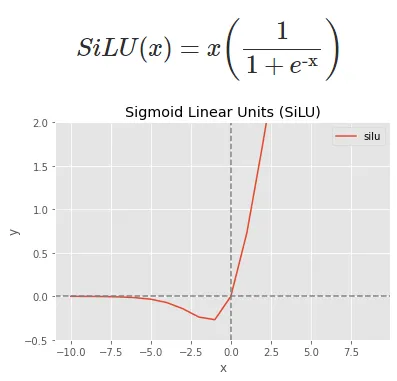
    
  - `out`: Final linear layer producing a single output logit.
  - `squeeze(1)`: Flattens the output from shape [B, 1] to [B], so it matches loss functions like BCEWithLogitsLoss

- **Forward Pass**:
  - Passes input through the backbone, applies a small custom classifier head, and returns the output logit.

In [ ]:
class BCModel(nn.Module):
    def __init__(self, model_name):
        super().__init__()
        self.backbone = timm.create_model(model_name, pretrained=True, num_classes=0, in_chans=3)
        self.backbone_dim = self.backbone.num_features
        self.act = nn.SiLU()
        self.fc1 = nn.Linear(self.backbone_dim, 32)
        self.out = nn.Linear(32, 1)

    def forward(self, x):
        x = self.backbone(x)
        x = self.act(self.fc1(x))    
        x = self.out(x).squeeze(-1)          
        return x    

### Focal Loss for Imbalanced Binary Classification

Defines a custom `FocalLoss` class for handling class imbalance in binary classification tasks:

- **Parameters**:
  - `alpha`: Weighting factor to reduce the relative loss for well-classified examples.
  - `gamma`: Focusing parameter that reduces loss for easy examples and emphasizes hard ones.

- **Forward Pass**:
  - Computes the standard binary cross-entropy loss (logits version).
  - Applies the focal loss formula: scales the BCE loss using the predicted probability (`pt`) and the focusing term `(1 - pt)^gamma`.
  - Averages the resulting loss over the batch.

In [12]:
# Losses
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.8, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        return (self.alpha * (1 - pt) ** self.gamma * BCE_loss).mean()

### Image Transformation Pipeline for Training and Validation

Defines a `build_transforms` function to apply preprocessing and augmentation to images:

---
  - Converts image arrays to PIL images (`T.ToPILImage()`).

- **Conditional Augmentations (for training)**:
  - Enabled only if `train=True` and `CFG.augment` is `True`.
  - Applies `ColorJitter` randomly based on `CFG.pixel_aug` probability.
  - Applies random horizontal and vertical flips depending on `CFG.hflip` and `CFG.vflip`.
  - Applies random rotation based on `CFG.rot`.

Using probability (e.g., 90% chance of applying `ColorJitter`) prevents over-augmenting the data. It ensures that not every image is distorted in the same way, helping the model generalize better by seeing a diverse set of variations without losing the original signal too often.

  - Converts images back to tensors (`T.ToTensor()`), suitable for PyTorch models.

- **Returns**:
  - A `torchvision.transforms.Compose` object containing the full augmentation pipeline.

In [13]:
# Transforms
def build_transforms(train=True):
    aug = [T.ToPILImage()]
    if train and CFG.augment:
        aug += [
            T.ColorJitter(CFG.bri, CFG.cont, CFG.sat, CFG.hue)
            if np.random.rand() < CFG.pixel_aug else T.Lambda(lambda x: x),
            T.RandomHorizontalFlip(p=0.5 if CFG.hflip else 0.0),
            T.RandomVerticalFlip(p=0.5 if CFG.vflip else 0.0),
            T.RandomRotation(degrees=CFG.rot)
        ]
    aug.append(T.ToTensor())
    return T.Compose(aug)

### Validation Loop

Validates the model using cancer predictions only, without auxiliary losses.

---

**Inputs**  
- `criterion`: Loss function for cancer prediction (e.g. FocalLoss or BCEWithLogitsLoss).  
- `threshold`: Optional probability threshold to compute classification metrics.  

---

**Validation Steps**  
- Sets model to evaluation mode with `model.eval()` and disables gradient computation using `torch.no_grad()`.  
- Uses `autocast(device_type='cuda', dtype=torch.float16')` for mixed precision inference.  
- For each batch:
  - Moves images and labels to the GPU.
  - Computes logits and loss.
  - Skips invalid loss values (`NaN` or `Inf`).
  - Applies `sigmoid` to outputs and collects predictions and targets.
  - Tracks running average loss with `tqdm`.

---

**Final Evaluation**  
- Concatenates all predictions and labels.
- Computes:
  - Either: threshold-based metrics (acc, prec, rec, F1) if enabled.
  - Or: probabilistic F1, AUC, and best threshold from validation.

---

**Returns**  
- Average validation loss and chosen evaluation metrics.

In [14]:
def validate(model, loader, criterion, device, threshold, use_classification_metrics=False):
    model.eval()
    running_loss = 0.0
    all_preds = []
    all_targets = []

    pbar = tqdm(loader, desc="[Valid]", leave=False)

    with torch.no_grad():
        for batch_idx, (images, targets) in enumerate(pbar):
            images, targets = images.to(device), targets.to(device)

            with autocast(device_type='cuda', dtype=torch.float16):
                outputs = model(images)
                loss = criterion(outputs, targets)

            if torch.isnan(loss) or torch.isinf(loss):
                print(f"Skipping batch {batch_idx} during validation (NaN or Inf loss).")
                continue

            running_loss += loss.item() * images.size(0)
            all_preds.append(outputs.detach().cpu())
            all_targets.append(targets.detach().cpu())

            seen_samples = (batch_idx + 1) * images.size(0)
            avg_loss = running_loss / seen_samples
            pbar.set_postfix(batch_loss=loss.item(), avg_loss=f"{avg_loss:.4f}")
            
    all_preds = torch.sigmoid(torch.cat(all_preds)).numpy()
    all_targets = torch.cat(all_targets).numpy()
    epoch_loss = running_loss / len(loader.dataset)

    if use_classification_metrics:
        metrics = compute_classification_metrics(all_preds, all_targets, threshold=threshold)
        print(f"[OOF Prediction] Metrics @ Thr={threshold:.4f} → "
              f"Acc: {metrics['acc']:.4f} | Prec: {metrics['prec']:.4f} | "
              f"Rec: {metrics['rec']:.4f} | F1: {metrics['f1']:.4f}")
        return epoch_loss, metrics, threshold
    else:
        pf1, pf1_thr, auc, best_thr = compute_metrics(all_preds, all_targets)
        print(f"[Val] Metrics → val_pf1: {pf1:.4f} | val_pf1_thr: {pf1_thr:.4f} | val_auc: {auc:.4f} | val_Best_Thr: {best_thr:.2f}")
        return epoch_loss, pf1, pf1_thr, auc, best_thr

### Training Loop (Cancer-Only Model) with Mixed Precision

Performs one training epoch for a binary classification model predicting breast cancer labels.

---

**Inputs**  
- `criterion`: Loss function for the main task (e.g. `FocalLoss`, `BCEWithLogitsLoss`).  
- `scaler`: `GradScaler` used to support AMP (Automatic Mixed Precision).  
- `epoch`: Current epoch number, used for logging.  

---

**Training Steps**  
- Enables training mode with `model.train()`.  
- Uses `autocast(device_type='cuda', dtype=torch.float16)` for mixed precision, improving memory efficiency and speed.  
- Iterates over each batch:
  - Moves input images and cancer labels to the device.  
  - Computes logits and loss.  
  - Skips the batch if the loss is NaN or Inf to prevent training instability.  
  - Performs backpropagation using scaled gradients (`scaler.scale(...)`).  
  - Updates model parameters using `scaler.step(...)` and `scaler.update()`.

---

**Metric Collection**  
- Applies `sigmoid` to outputs to get predicted probabilities.  
- Collects predictions and ground-truth labels to compute metrics at the end of the epoch.  
- Displays real-time batch loss and running average using `tqdm`.

---

**Returns**  
- Average training loss and evaluation metrics:  
  - **Probabilistic F1 (pF1)**  
  - **Thresholded F1**  
  - **AUC**  
  - **Best threshold**

In [15]:
def train_one_epoch(model, loader, optimizer, criterion, device, scaler, epoch):
    model.train()
    running_loss, preds, targets_list = 0.0, [], []

    pbar = tqdm(loader, desc=f"[Train] Epoch {epoch+1}", leave=False)
    for batch_idx, (images, targets) in enumerate(pbar):
        images, targets = images.to(device), targets.to(device)
        optimizer.zero_grad()

        with autocast(device_type='cuda', dtype=torch.float16):
            outputs = model(images)
            loss = criterion(outputs, targets)

        # Skip if loss is NaN
        if torch.isnan(loss) or torch.isinf(loss):
            print(f"Skipping batch {batch_idx} due to invalid loss.")
            continue

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        preds.append(outputs.detach().cpu())
        targets_list.append(targets.detach().cpu())
        running_loss += loss.item() * images.size(0)

        seen_samples = (batch_idx + 1) * images.size(0)
        avg_loss = running_loss / seen_samples
        pbar.set_postfix(batch_loss=loss.item(), avg_loss=f"{avg_loss:.4f}")

    preds = torch.sigmoid(torch.cat(preds)).numpy()
    targets = torch.cat(targets_list).numpy()
    pf1, pf1_thr, auc, best_thr = compute_metrics(preds, targets)
    epoch_loss = running_loss / len(loader.dataset)
    
    print(f"[Train Epoch {epoch+1}] loss: {epoch_loss:.4f} | pf1: {pf1:.4f} | pf1_thr: {pf1_thr:.4f} | AUC: {auc:.4f} | Best Thr: {best_thr:.4f}")

    return epoch_loss, pf1, pf1_thr, auc, best_thr

### Cross-Validation Training Loop and Out-of-Fold Evaluation Loop

This is the main training loop that handles K-fold cross-validation, model training, validation, and out-of-fold (OOF) evaluation:

- **Initialization**:
  - Sets up lists to track per-epoch results, OOF metrics, and best thresholds.
  - Prepares tracking for the best overall model across folds.

- **Per-Fold Loop**:
  - Splits `train_df` into training and validation sets based on fold index.
  - Creates datasets and dataloaders with appropriate transforms.
  - Initializes model, optimizer (Adam), loss function (`FocalLoss` or `BCEWithLogitsLoss`), and gradient scaler for AMP.

- **Per-Epoch Training**:
  - Trains and validates the model.
  - Computes performance metrics like probabilistic F1 (pF1), thresholded F1, AUC, and best threshold.
  - Saves the model if the validation pF1 improves.

- **Out-of-Fold (OOF) Evaluation**:
  - Reloads the best model for the current fold.
  - Evaluates on the fold's validation data using the best threshold.
  - Saves OOF metrics (accuracy, precision, recall, F1).

- **Cleanup**:
  - Deletes models and loaders to free up GPU memory and calls `torch.cuda.empty_cache()`.

- **Final Output**:
  - Saves all epoch-level training results to `cv_epoch_results.csv`.
  - Saves OOF results to `cv_oof_results.csv`.
  - Prints the path of the best-performing model across all folds.

In [16]:
# Track across folds
fold_epoch_results = []
oof_records = []
best_fold_model_path = None
best_fold_val_pF1_thr = -np.inf
fold_best_thresholds = {}

# Main Training Loop
for fold in CFG.selected_folds:
    print(f"\n### FOLD: {fold} | IMAGE_SIZE: {CFG.img_size} | MODEL_NAME: {CFG.model_name} | BATCH_SIZE: {CFG.batch_size}")

    train_fold_df = train_df[train_df['fold'] != fold].reset_index(drop=True)
    valid_df = train_df[train_df['fold'] == fold].reset_index(drop=True)

    train_dataset = BreastCancerDataset(train_fold_df, transform=build_transforms(True))
    valid_dataset = BreastCancerDataset(valid_df, transform=build_transforms(False))

    train_loader = DataLoader(train_dataset, batch_size=CFG.batch_size, shuffle=True, num_workers=8)
    valid_loader = DataLoader(valid_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=8)
    
    model = BCModel(CFG.model_name).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=CFG.learning_rate)
    criterion = FocalLoss() if CFG.loss == 'focal' else nn.BCEWithLogitsLoss()
    scaler = GradScaler()

    best_thr_this_fold = None
    best_val_pF1_thr = -np.inf
    best_metrics = None
    best_epoch_idx = 0

    print("Training...")
    for epoch in range(CFG.epochs):
        train_loss, train_pF1, train_pF1_thr, train_auc, train_best_thr  = train_one_epoch(model, train_loader, optimizer, criterion, device, scaler, epoch)
        val_loss, val_pF1, val_pF1_thr, val_auc, val_best_thr = validate(model, valid_loader, criterion, device, threshold=None, use_classification_metrics=False)

        lr = optimizer.param_groups[0]['lr']

        improved = val_pF1_thr > best_val_pF1_thr
        if improved:
            best_val_pF1_thr = val_pF1_thr
            best_thr_this_fold = val_best_thr
            model_path = f"model_fold{fold}.pth"
            torch.save(model.state_dict(), model_path)

            best_epoch_idx = epoch
            best_metrics = {
                "fold": fold,
                "epoch": epoch + 1,
                "train_loss": train_loss,
                "train_pF1": train_pF1,
                "train_pF1_thr": train_pF1_thr,
                "train_auc": train_auc,
                "val_loss": val_loss,
                "val_pF1": val_pF1,
                "val_pF1_thr": val_pF1_thr,
                "val_auc": val_auc,
            }
            
            print(f"Epoch {epoch+1}: val_pF1_thr improved, saving model to {model_path}")

            if best_val_pF1_thr > best_fold_val_pF1_thr:
                best_fold_val_pF1_thr = best_val_pF1_thr
                best_fold_model_path = model_path

        fold_epoch_results.append({
            "fold": fold,
            "epoch": epoch + 1,
            "train_loss": train_loss,
            "train_pF1": train_pF1,
            "train_pF1_thr": train_pF1_thr,
            "train_auc": train_auc,
            "val_loss": val_loss,
            "val_pF1": val_pF1,
            "val_pF1_thr": val_pF1_thr,
            "val_auc": val_auc,
        })
        
    fold_best_thresholds[fold] = best_thr_this_fold
    print(f"Finished Fold {fold} | Best val_pF1_thr: {best_val_pF1_thr:.5f}")

    # OOF Prediction
    print("Evaluating best model for OOF...")
    best_model = BCModel(CFG.model_name).to(device)
    best_model.load_state_dict(torch.load(f"model_fold{fold}.pth"))
    criterion = FocalLoss() if CFG.loss == 'focal' else nn.BCEWithLogitsLoss()

    oof_loss, oof_metrics, _ = validate(
        best_model, valid_loader, criterion, device,
        threshold=best_thr_this_fold, use_classification_metrics=True
    )

    # Save OOF metrics
    oof_records.append({
        "fold": fold,
        "oof_loss": oof_loss,
        "oof_f1": oof_metrics["f1"],
        "oof_acc": oof_metrics["acc"],
        "oof_prec": oof_metrics["prec"],
        "oof_rec": oof_metrics["rec"],
        "oof_best_thr": best_thr_this_fold
    })


    # --- Clean up ---
    del model, optimizer, train_loader, valid_loader, scaler, criterion, best_model
    torch.cuda.empty_cache()

# --- Save all epoch-level results to CSV ---
epoch_df = pd.DataFrame(fold_epoch_results)
epoch_df.to_csv("cv_epoch_results.csv", index=False)
print("Epoch-wise fold results saved to cv_epoch_results.csv")

# SAVE OOF RESULTS
pd.DataFrame(oof_records).to_csv("cv_oof_results.csv", index=False)
print("OOF fold results saved to cv_oof_results.csv")

# Best Model across folds
print(f"Best model path across all folds: {best_fold_model_path}")


### FOLD: 0 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.0973 | pf1: 0.2993 | pf1_thr: 0.2919 | AUC: 0.5432 | Best Thr: 0.3265


[Val] Metrics → val_pf1: 0.2992 | val_pf1_thr: 0.3255 | val_auc: 0.6191 | val_Best_Thr: 0.35
Epoch 1: val_pF1_thr improved, saving model to model_fold0.pth


[Train Epoch 2] loss: 0.0901 | pf1: 0.3062 | pf1_thr: 0.3462 | AUC: 0.6533 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.3107 | val_pf1_thr: 0.3536 | val_auc: 0.6475 | val_Best_Thr: 0.37
Epoch 2: val_pF1_thr improved, saving model to model_fold0.pth


[Train Epoch 3] loss: 0.0817 | pf1: 0.3365 | pf1_thr: 0.4348 | AUC: 0.7447 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3230 | val_pf1_thr: 0.3652 | val_auc: 0.6446 | val_Best_Thr: 0.35
Epoch 3: val_pF1_thr improved, saving model to model_fold0.pth


[Train Epoch 4] loss: 0.0736 | pf1: 0.3705 | pf1_thr: 0.5160 | AUC: 0.8150 | Best Thr: 0.4082


[Val] Metrics → val_pf1: 0.2891 | val_pf1_thr: 0.3604 | val_auc: 0.6323 | val_Best_Thr: 0.33


[Train Epoch 5] loss: 0.0612 | pf1: 0.4239 | pf1_thr: 0.6120 | AUC: 0.8822 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3032 | val_pf1_thr: 0.3103 | val_auc: 0.5818 | val_Best_Thr: 0.41


[Train Epoch 6] loss: 0.0514 | pf1: 0.4713 | pf1_thr: 0.7094 | AUC: 0.9210 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3221 | val_pf1_thr: 0.3636 | val_auc: 0.6430 | val_Best_Thr: 0.43


[Train Epoch 7] loss: 0.0404 | pf1: 0.5399 | pf1_thr: 0.7771 | AUC: 0.9525 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3114 | val_pf1_thr: 0.3472 | val_auc: 0.6564 | val_Best_Thr: 0.31


[Train Epoch 8] loss: 0.0279 | pf1: 0.6239 | pf1_thr: 0.8480 | AUC: 0.9785 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.2931 | val_pf1_thr: 0.3250 | val_auc: 0.6032 | val_Best_Thr: 0.33
Finished Fold 0 | Best val_pF1_thr: 0.36522
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.3469 → Acc: 0.7378 | Prec: 0.3070 | Rec: 0.4506 | F1: 0.3652

### FOLD: 1 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.0980 | pf1: 0.3015 | pf1_thr: 0.2939 | AUC: 0.5575 | Best Thr: 0.3265


[Val] Metrics → val_pf1: 0.3102 | val_pf1_thr: 0.3018 | val_auc: 0.5665 | val_Best_Thr: 0.35
Epoch 1: val_pF1_thr improved, saving model to model_fold1.pth


[Train Epoch 2] loss: 0.0871 | pf1: 0.3141 | pf1_thr: 0.3767 | AUC: 0.6937 | Best Thr: 0.3673


[Val] Metrics → val_pf1: 0.3252 | val_pf1_thr: 0.3460 | val_auc: 0.6348 | val_Best_Thr: 0.37
Epoch 2: val_pF1_thr improved, saving model to model_fold1.pth


[Train Epoch 3] loss: 0.0770 | pf1: 0.3552 | pf1_thr: 0.4853 | AUC: 0.7939 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3073 | val_pf1_thr: 0.3344 | val_auc: 0.6563 | val_Best_Thr: 0.35


[Train Epoch 4] loss: 0.0625 | pf1: 0.4142 | pf1_thr: 0.6041 | AUC: 0.8781 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3336 | val_pf1_thr: 0.3270 | val_auc: 0.6271 | val_Best_Thr: 0.35


[Train Epoch 5] loss: 0.0497 | pf1: 0.4808 | pf1_thr: 0.7129 | AUC: 0.9276 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.2824 | val_pf1_thr: 0.3333 | val_auc: 0.6296 | val_Best_Thr: 0.22


[Train Epoch 6] loss: 0.0341 | pf1: 0.5744 | pf1_thr: 0.8174 | AUC: 0.9683 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.2747 | val_pf1_thr: 0.3285 | val_auc: 0.6040 | val_Best_Thr: 0.31


[Train Epoch 7] loss: 0.0292 | pf1: 0.6180 | pf1_thr: 0.8424 | AUC: 0.9769 | Best Thr: 0.4898


[Val] Metrics → val_pf1: 0.3288 | val_pf1_thr: 0.3689 | val_auc: 0.6583 | val_Best_Thr: 0.33
Epoch 7: val_pF1_thr improved, saving model to model_fold1.pth


[Train Epoch 8] loss: 0.0205 | pf1: 0.6923 | pf1_thr: 0.8942 | AUC: 0.9880 | Best Thr: 0.4898


[Val] Metrics → val_pf1: 0.3563 | val_pf1_thr: 0.3936 | val_auc: 0.6745 | val_Best_Thr: 0.41
Epoch 8: val_pF1_thr improved, saving model to model_fold1.pth
Finished Fold 1 | Best val_pF1_thr: 0.39357
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.4082 → Acc: 0.7873 | Prec: 0.3769 | Rec: 0.4118 | F1: 0.3936

### FOLD: 2 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.0948 | pf1: 0.2996 | pf1_thr: 0.2980 | AUC: 0.5726 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.3011 | val_pf1_thr: 0.3070 | val_auc: 0.5289 | val_Best_Thr: 0.31
Epoch 1: val_pF1_thr improved, saving model to model_fold2.pth


[Train Epoch 2] loss: 0.0868 | pf1: 0.3105 | pf1_thr: 0.3598 | AUC: 0.6855 | Best Thr: 0.3673


[Val] Metrics → val_pf1: 0.2913 | val_pf1_thr: 0.3318 | val_auc: 0.6118 | val_Best_Thr: 0.31
Epoch 2: val_pF1_thr improved, saving model to model_fold2.pth


[Train Epoch 3] loss: 0.0801 | pf1: 0.3346 | pf1_thr: 0.4324 | AUC: 0.7560 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3084 | val_pf1_thr: 0.3612 | val_auc: 0.6417 | val_Best_Thr: 0.35
Epoch 3: val_pF1_thr improved, saving model to model_fold2.pth


[Train Epoch 4] loss: 0.0720 | pf1: 0.3675 | pf1_thr: 0.5164 | AUC: 0.8179 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3165 | val_pf1_thr: 0.3644 | val_auc: 0.6576 | val_Best_Thr: 0.35
Epoch 4: val_pF1_thr improved, saving model to model_fold2.pth


[Train Epoch 5] loss: 0.0619 | pf1: 0.4111 | pf1_thr: 0.5912 | AUC: 0.8756 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3360 | val_pf1_thr: 0.3651 | val_auc: 0.6618 | val_Best_Thr: 0.29
Epoch 5: val_pF1_thr improved, saving model to model_fold2.pth


[Train Epoch 6] loss: 0.0494 | pf1: 0.4781 | pf1_thr: 0.6932 | AUC: 0.9266 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3069 | val_pf1_thr: 0.3514 | val_auc: 0.6356 | val_Best_Thr: 0.27


[Train Epoch 7] loss: 0.0404 | pf1: 0.5372 | pf1_thr: 0.7790 | AUC: 0.9505 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.2726 | val_pf1_thr: 0.3553 | val_auc: 0.6336 | val_Best_Thr: 0.20


[Train Epoch 8] loss: 0.0299 | pf1: 0.6096 | pf1_thr: 0.8491 | AUC: 0.9732 | Best Thr: 0.5102


[Val] Metrics → val_pf1: 0.3100 | val_pf1_thr: 0.3537 | val_auc: 0.6267 | val_Best_Thr: 0.22
Finished Fold 2 | Best val_pF1_thr: 0.36514
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.2857 → Acc: 0.5923 | Prec: 0.2533 | Rec: 0.6540 | F1: 0.3651

### FOLD: 3 | IMAGE_SIZE: (512, 512) | MODEL_NAME: tf_efficientnet_b4.ns_jft_in1k | BATCH_SIZE: 16
Training...


[Train Epoch 1] loss: 0.0994 | pf1: 0.3074 | pf1_thr: 0.3041 | AUC: 0.5577 | Best Thr: 0.3469


[Val] Metrics → val_pf1: 0.2798 | val_pf1_thr: 0.2791 | val_auc: 0.5766 | val_Best_Thr: 0.33
Epoch 1: val_pF1_thr improved, saving model to model_fold3.pth


[Train Epoch 2] loss: 0.0910 | pf1: 0.3133 | pf1_thr: 0.3584 | AUC: 0.6615 | Best Thr: 0.3673


[Val] Metrics → val_pf1: 0.2972 | val_pf1_thr: 0.3371 | val_auc: 0.6681 | val_Best_Thr: 0.35
Epoch 2: val_pF1_thr improved, saving model to model_fold3.pth


[Train Epoch 3] loss: 0.0837 | pf1: 0.3371 | pf1_thr: 0.4325 | AUC: 0.7450 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3191 | val_pf1_thr: 0.3752 | val_auc: 0.6932 | val_Best_Thr: 0.39
Epoch 3: val_pF1_thr improved, saving model to model_fold3.pth


[Train Epoch 4] loss: 0.0737 | pf1: 0.3756 | pf1_thr: 0.5205 | AUC: 0.8248 | Best Thr: 0.3878


[Val] Metrics → val_pf1: 0.3112 | val_pf1_thr: 0.3693 | val_auc: 0.6833 | val_Best_Thr: 0.37


[Train Epoch 5] loss: 0.0631 | pf1: 0.4270 | pf1_thr: 0.6208 | AUC: 0.8765 | Best Thr: 0.4286


[Val] Metrics → val_pf1: 0.3004 | val_pf1_thr: 0.3529 | val_auc: 0.6744 | val_Best_Thr: 0.35


[Train Epoch 6] loss: 0.0527 | pf1: 0.4789 | pf1_thr: 0.7064 | AUC: 0.9193 | Best Thr: 0.4490


[Val] Metrics → val_pf1: 0.3122 | val_pf1_thr: 0.3228 | val_auc: 0.6407 | val_Best_Thr: 0.33


[Train Epoch 7] loss: 0.0415 | pf1: 0.5462 | pf1_thr: 0.7763 | AUC: 0.9526 | Best Thr: 0.4898


[Val] Metrics → val_pf1: 0.3186 | val_pf1_thr: 0.3643 | val_auc: 0.6905 | val_Best_Thr: 0.37


[Train Epoch 8] loss: 0.0310 | pf1: 0.6094 | pf1_thr: 0.8465 | AUC: 0.9731 | Best Thr: 0.4694


[Val] Metrics → val_pf1: 0.2537 | val_pf1_thr: 0.3255 | val_auc: 0.6455 | val_Best_Thr: 0.16
Finished Fold 3 | Best val_pF1_thr: 0.37520
Evaluating best model for OOF...


[OOF Prediction] Metrics @ Thr=0.3878 → Acc: 0.7314 | Prec: 0.2911 | Rec: 0.5275 | F1: 0.3752
Epoch-wise fold results saved to cv_epoch_results.csv
OOF fold results saved to cv_oof_results.csv
Best model path across all folds: model_fold1.pth


### Plot Training and Validation Metrics per Fold

This code block visualizes training progress and performance metrics across all folds:

- **Load Data**: Reads `cv_epoch_results.csv` into `results_df`, containing per-epoch training/validation results.

- **Metrics to Plot**: Lists 8 metrics including loss, pF1, thresholded F1, and AUC for both train and validation sets.

- **Per-Metric Plotting**:
  - For each metric, plots its value over epochs for each fold.
  - Adds labels, titles, grid lines, and legends to each subplot.
  - Skips and disables plotting for metrics not found in the CSV (with a warning).

- **Post-processing**:
  - Hides any unused subplots (in case grid has extra slots).
  - Adjusts layout and adds a supertitle to the figure.
  - Saves the plot to `metrics_per_fold.png` and displays it.


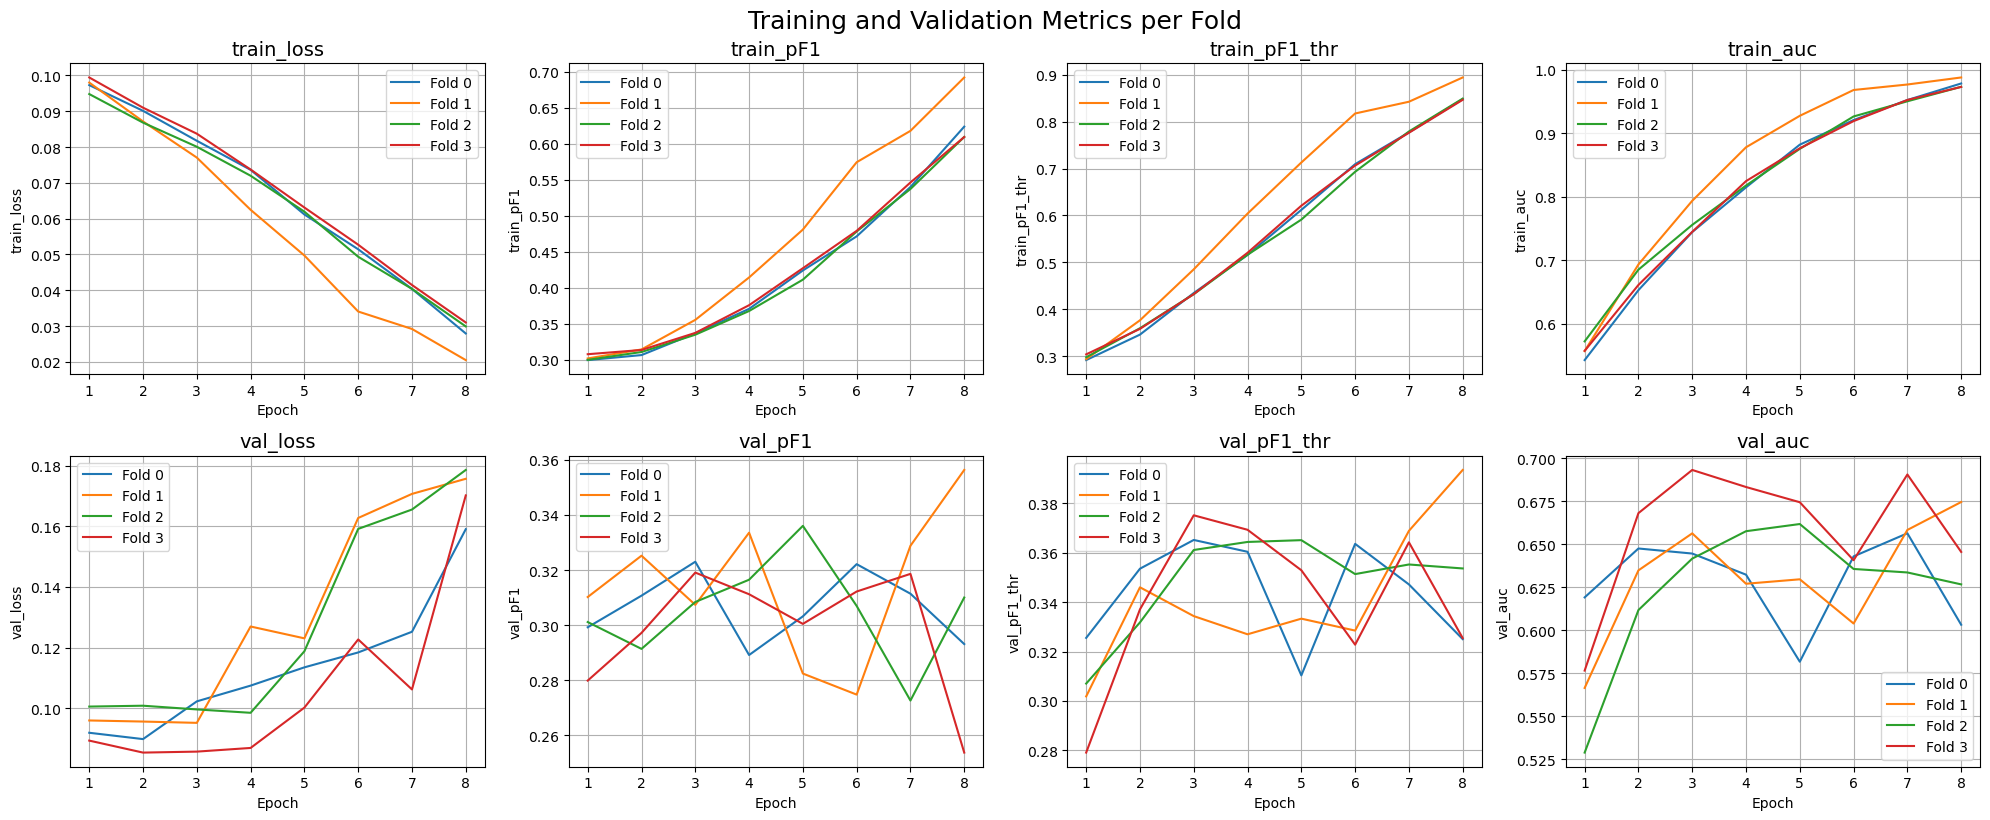

In [17]:
results_df = pd.read_csv("cv_epoch_results.csv")

metrics = [
    'train_loss', 'train_pF1','train_pF1_thr', 'train_auc',
    'val_loss', 'val_pF1', 'val_pF1_thr', 'val_auc']

n_cols = 4
n_rows = (len(metrics) + n_cols - 1) // n_cols
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 4 * n_rows))
axs = axs.flatten()

for idx, metric in enumerate(metrics):
    ax = axs[idx]
    if metric not in results_df.columns:
        print(f"Warning: '{metric}' not found in DataFrame columns. Skipping.")
        ax.axis('off')
        continue
    for fold in sorted(results_df['fold'].unique()):
        fold_data = results_df[results_df['fold'] == fold]
        ax.plot(fold_data['epoch'], fold_data[metric], label=f"Fold {fold}")
    ax.set_title(metric, fontsize=14)
    ax.set_xlabel("Epoch")
    ax.set_ylabel(metric)
    ax.grid(True)
    ax.legend()

# Hide unused axes
for i in range(len(metrics), len(axs)):
    axs[i].axis('off')

plt.tight_layout()
plt.suptitle("Training and Validation Metrics per Fold", fontsize=18, y=1.02)
plt.savefig("metrics_per_fold.png")
plt.show()

### Grad-CAM Utility Functions

Provides tools to generate and visualize Grad-CAM heatmaps for the main cancer classification output:

---

**Function: `generate_gradcam_heatmap(model, image_tensor, target_layer)`**  
- Registers forward and backward hooks to capture:
  - **Activations** from the selected `target_layer`.
  - **Gradients** during the backward pass.
- Performs a forward pass to obtain the **cancer output**.
- Applies `sigmoid` and triggers `backward()` on the scalar prediction.
- Removes hooks and computes the Grad-CAM heatmap:
  - Averages gradients spatially to get importance weights.
  - Combines weights with feature activations.
  - Applies ReLU and normalizes the result.

**Returns**:
- The normalized heatmap.
- The predicted probability score for the cancer output.

---

**Function: `overlay_gradcam_on_image(original_img, heatmap, alpha=0.4)`**  
- Resizes the Grad-CAM heatmap to the original image size.
- Applies a JET color map to the heatmap.
- Overlays it with the original image using a transparency factor `alpha`.
- Converts the image back to RGB format.

**Returns**:
- An RGB image with the Grad-CAM heatmap visually overlaid for interpretation.

In [18]:
# GRADCAM
def generate_gradcam_heatmap(model, image_tensor, target_layer):
    activations = []
    gradients = []

    def save_features_hook(module, input, output):
        activations.append(output.detach())

    def save_gradients_hook(module, grad_input, grad_output):
        gradients.append(grad_output[0].detach())

    forward_hook = target_layer.register_forward_hook(save_features_hook)
    backward_hook = target_layer.register_full_backward_hook(save_gradients_hook)

    model.zero_grad()
    output = model(image_tensor.unsqueeze(0))
    pred_score = torch.sigmoid(output)
    pred_score.backward()

    forward_hook.remove()
    backward_hook.remove()

    gradients_data = gradients[0].squeeze(0).cpu().numpy()
    activations_data = activations[0].squeeze(0).cpu().numpy()

    weights = np.mean(gradients_data, axis=(1, 2))
    cam = np.sum(weights[:, np.newaxis, np.newaxis] * activations_data, axis=0)

    cam = np.maximum(cam, 0)
    cam = cam / (np.max(cam) + 1e-7)
    return cam, pred_score.item()

def overlay_gradcam_on_image(original_img, heatmap, alpha=0.4):
    heatmap_resized = cv2.resize(heatmap, (original_img.shape[1], original_img.shape[0]))
    heatmap_uint8 = np.uint8(255 * heatmap_resized)
    colored_heatmap = cv2.applyColorMap(heatmap_uint8, cv2.COLORMAP_JET)

    original_bgr = cv2.cvtColor(original_img, cv2.COLOR_RGB2BGR)
    overlay_bgr = cv2.addWeighted(colored_heatmap, alpha, original_bgr, 1 - alpha, 0)
    overlay_rgb = cv2.cvtColor(overlay_bgr, cv2.COLOR_BGR2RGB)

    return overlay_rgb

### Evaluate Best Model on Test Set and Visualize Predictions with Grad-CAM

This block performs final model evaluation on the held-out test set and visualizes selected predictions using Grad-CAM:

---

#### **Test Inference:**
- **Dataset & Loader**: Creates a test dataset and DataLoader with no augmentation.
- **Load Best Model**: Loads the best model checkpoint saved during cross-validation.
- **Inference Loop**:
  - Uses `torch.no_grad()` and `autocast` for efficient inference.
  - Applies sigmoid to logits to get predicted probabilities.
  - Collects predictions and ground truths in `test_df`.

#### **Metric Evaluation:**
- Calculates:
  - Probabilistic F1 (`pF1`)
  - Best thresholded F1
  - AUC
- Prints the final evaluation metrics and saves `test_predictions.csv`.

---

#### **Grad-CAM Visualization:**
- **Sample Selection**:
  - Selects three samples with the **lowest**, **middle**, and **highest** prediction scores from the test set.

- **Grad-CAM Generation**:
  - Loads and preprocesses each image.
  - Selects `model.backbone.blocks[-2]` as the Grad-CAM target layer.
  - Generates and overlays the Grad-CAM heatmap.

- **Display**:
  - Plots and saves the Grad-CAM overlays for the three samples in a single figure: `test_sample_predictions_with_gradcam.png`.


Testing on test split: 100%|██████████| 87/87 [00:20<00:00,  4.24it/s]



--- TEST RESULTS ---
AUC:        0.7141
pF1 (prob): 0.3515
pF1 (thr):  0.4135
Test predictions saved to test_predictions.csv
Sample test predictions with GradCAM saved to test_sample_predictions_with_gradcam.png


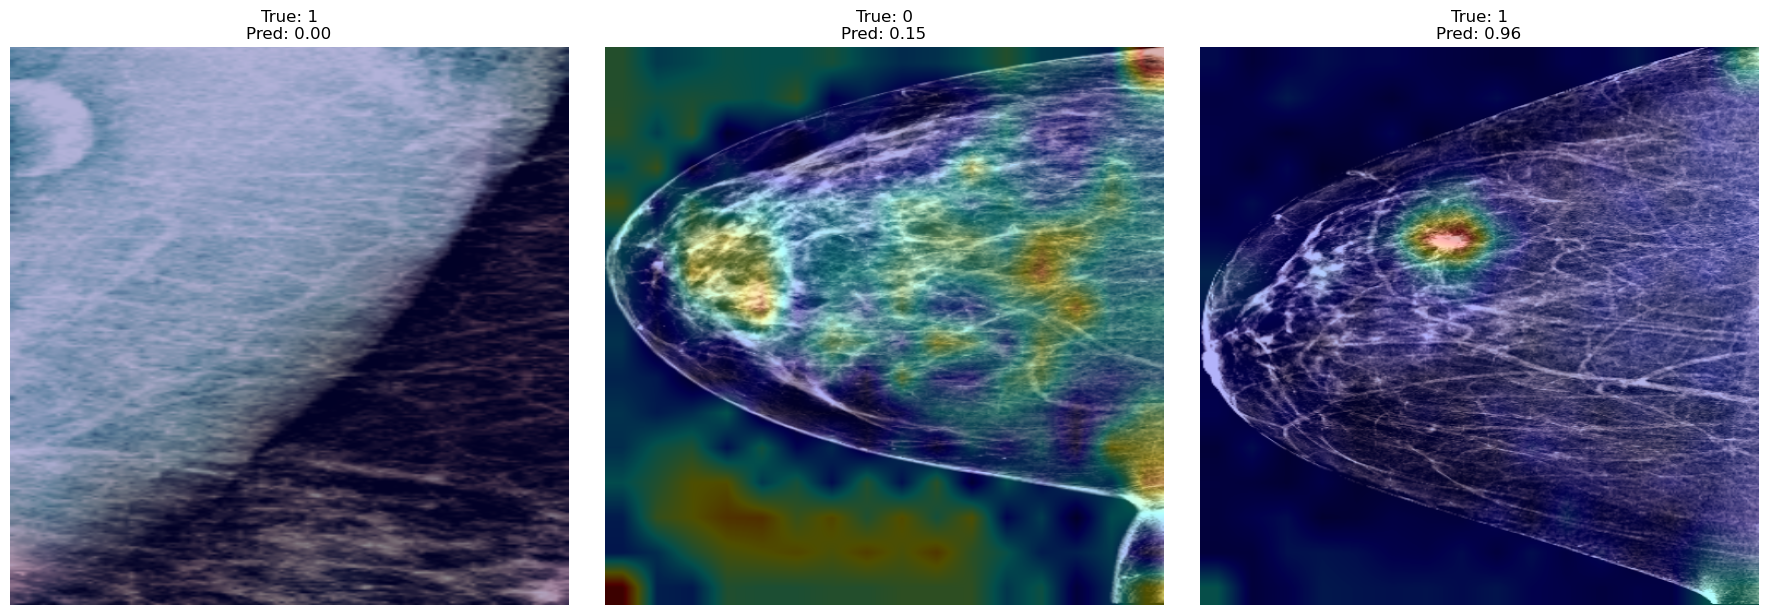

In [19]:
# TEST DATASET AND LOADER
test_dataset = BreastCancerDataset(test_df, transform=build_transforms(False))
test_loader = DataLoader(test_dataset, batch_size=CFG.batch_size, shuffle=False, num_workers=8)

# LOAD BEST MODEL
model = BCModel(CFG.model_name).to(device)
model.load_state_dict(torch.load(best_fold_model_path))
model.eval()

all_preds = []
all_targets = []

with torch.no_grad():
    for images, targets in tqdm(test_loader, desc="Testing on test split"):
        images = images.to(device)
        targets = targets.to(device)

        with autocast(device_type='cuda'):
            outputs = model(images)
            preds = torch.sigmoid(outputs).detach().cpu().numpy()

        all_preds.extend(preds)
        all_targets.extend(targets.cpu().numpy())

test_df['pred'] = all_preds
test_df['target'] = all_targets

pf1, best_thr_f1, auc, _ = compute_metrics(test_df['pred'].values, test_df['target'].values)

print(f"\n--- TEST RESULTS ---")
print(f"AUC:        {auc:.4f}")
print(f"pF1 (prob): {pf1:.4f}")
print(f"pF1 (thr):  {best_thr_f1:.4f}")

test_df.to_csv("test_predictions.csv", index=False)
print("Test predictions saved to test_predictions.csv")

# SAMPLING WITH GRADCAM
sorted_df = test_df.sort_values(by="pred").reset_index(drop=True)

# GET LOWEST, MIDDLE, HIGHEST PREDICTION
lowest  = sorted_df.iloc[0]
middle  = sorted_df.iloc[len(sorted_df) // 2]
highest = sorted_df.iloc[-1]


sampled = pd.DataFrame([lowest, middle, highest])
fig, axs = plt.subplots(1, 3, figsize=(18, 6))

for i, row in enumerate(sampled.itertuples()):
    img = cv2.imread(row.image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_resized = cv2.resize(img, CFG.img_size[::-1])

    img_tensor = torch.tensor(img_resized / 255.0, dtype=torch.float32).permute(2, 0, 1).to(device)

    target_layer = model.backbone.blocks[-2]
    heatmap, _ = generate_gradcam_heatmap(model, img_tensor, target_layer)

    overlay = overlay_gradcam_on_image(img_resized, heatmap, alpha=0.3)

    axs[i].imshow(overlay)
    axs[i].axis('off')
    axs[i].set_title(f"True: {int(row.target)}\nPred: {row.pred:.2f}", fontsize=12)

plt.tight_layout()
plt.savefig("test_sample_predictions_with_gradcam.png")
print("Sample test predictions with GradCAM saved to test_sample_predictions_with_gradcam.png")